### Import libraries

In [1]:
import os
import sys

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# import own modules
sys.path.append(os.path.join("..", ".."))  # Adds higher directory to python modules path.
from scripts import preprocessing as pp
from scripts import evaluate_models as em

# plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')
plt.style.use(
    "https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle"
)

---
## Preparations

### Load the CSV into a Dataframe

- load csv (or calculate again if not in data folder)
- update index=id
- drop useless columns
- find numerical & object columns

In [2]:
# path to csv file
path_df = os.path.join("..", "..", "data", "df_deep_sam.csv")

# get features
df = pd.read_csv(path_df)

# set id as index
df = df.set_index("id", drop=True)

# drop first batch of useless variables
df = df.drop(columns=["img", "sp_idx"])
df = df.drop(columns=[col for col in df.columns if "_obj" in col])
df = df.drop(columns=[col for col in df.columns if "sam_sal_" in col])

# find numerical and categorical columns
num_cols = df.columns[df.dtypes != "object"]
cat_cols = df.columns[df.dtypes == "object"]

# print info
print(f" -> dataframe has {df.shape[0]} instances and {df.shape[1]} columns")
print(f" -> there are {len(num_cols)} numerical columns")
print(f" -> there are {len(cat_cols)} categoricals columns")

 -> dataframe has 7598 instances and 34 columns
 -> there are 34 numerical columns
 -> there are 0 categoricals columns


### First, drop instances & features

- unusual long fixation durations are identified as outliers and dropped
  - drop if "dur > 5000 ms"


In [3]:
# processing
df = df[df["sp_fix_duration_ms_total"] <= 5000]

# find numerical and categorical columns
num_cols = df.columns[df.dtypes != "object"]
cat_cols = df.columns[df.dtypes == "object"]

# print info
print(f" -> dataframe has {df.shape[0]} instances and {df.shape[1]} columns")
print(f" -> there are {len(num_cols)} numerical columns")
print(f" -> there are {len(cat_cols)} categoricals columns")

 -> dataframe has 7217 instances and 34 columns
 -> there are 34 numerical columns
 -> there are 0 categoricals columns


### Split into train & test sets

As soon as the dataset is in its final form, perform train-test-split with our own split function to have out 30-image-set always as our test set.

In [4]:
# prepare features and target
X = df
y = X.pop("asd")

# train-test-split
X_train, X_test, y_train, y_test = pp.split(X, y)

# print info
print(f"train-set has '{len(y_train)}' samples & '{X.shape[1]}' features")
print(f"test-set has '{len(y_test)}' samples - out of '{df.shape[0]}'")
print(f"  ~ {len(y_test) / df.shape[0] * 100:.2f}% of full dataset")

train-set has '6485' samples & '33' features
test-set has '732' samples - out of '7217'
  ~ 10.14% of full dataset


### Set variables

- define `metric`
- behavior for saving models as pickles
- defaults for model-objects

In [5]:
# metric
ftwo_scorer = make_scorer(fbeta_score, beta=2)

# models
folder_name = os.path.join("..", "..", "models", "dev", "RF_RFE_CV")

# defaults
RSEED = 42
cv = 10
n_jobs = -1
verbose = 0

###  Pipelines for each Model

In [6]:
# Random Forest: no scaling / no encoding
rf_pipeline = Pipeline(
    [
        (
            "classifier",
            RandomForestClassifier(
                random_state=RSEED,
                n_jobs=n_jobs,
                verbose=0,
            ),
        )
    ]
)

---
## Modeling

### Random Forest

defaults: _no restrictions whatsoever_

In [7]:
# Create GridSearchCV object & fit it
rf_defaults = RandomForestClassifier(
    random_state=RSEED,
    n_jobs=n_jobs,
    verbose=0,
)

In [8]:
# set file & folder name
model_name = "RF_defaults.pickle"

# fit or load
rf_defaults = em.fit_or_load(
    rf_defaults, X_train, y_train, model_name, folder=folder_name
)

 -> model saved in: '../../models/dev/RF_RFE_CV/RF_defaults.pickle'


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      3252
           1      1.000     1.000     1.000      3233

    accuracy                          1.000      6485
   macro avg      1.000     1.000     1.000      6485
weighted avg      1.000     1.000     1.000      6485

f(0.5)-score: 1.000
f(2.0)-score: 1.000

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.659     0.714     0.686       371
           1      0.679     0.620     0.648       361

    accuracy                          0.668       732
   macro avg      0.669     0.667     0.667       732
weighted avg      0.669     0.668     0.667       732

f(0.5)-score: 0.666
f(2.0)-score: 0.631



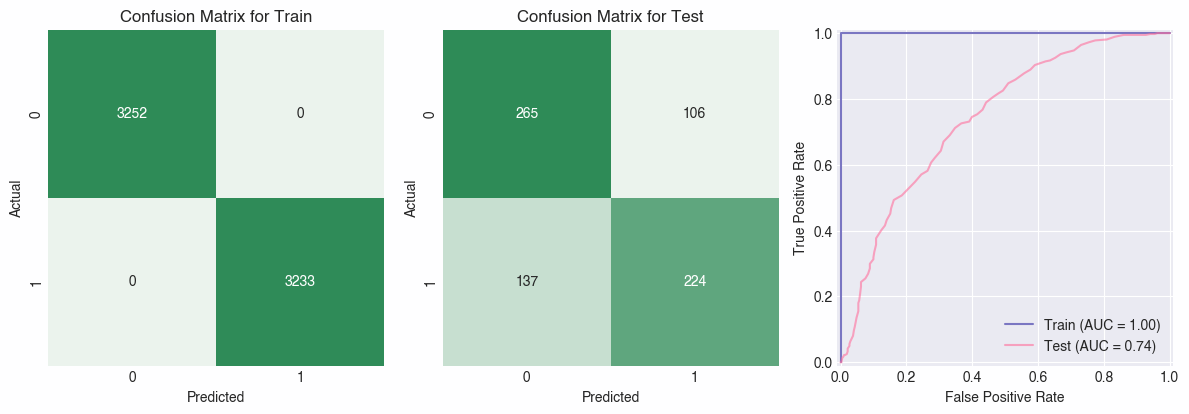

In [9]:
# predict & proba
pred_test = rf_defaults.predict(X_test)
proba_test = rf_defaults.predict_proba(X_test)

pred_train = rf_defaults.predict(X_train)
proba_train = rf_defaults.predict_proba(X_train)

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

In [10]:
# Get the best parameters and best estimator
em.model_info(rf_defaults)


 ----- RandomForestClassifier -----
   has on average 2098 nodes
   has on average a maximum depth of 26



----
----

### feature selection

#### RFE

In [11]:
estimator = RandomForestClassifier(
    random_state=RSEED,
    n_jobs=n_jobs,
    verbose=0,
)
selector_RFE = RFE(estimator, verbose=0)
selector_RFE = selector_RFE.fit(X_train, y_train)
feat_RFE = selector_RFE.get_feature_names_out()
print(f"selected {selector_RFE.n_features_} features: {feat_RFE}")

selected 16 features: ['sp_fix_duration_ms_total' 'sp_fix_duration_ms_mean'
 'sp_fix_duration_ms_var' 'sp_len_px_total' 'sp_saccade_amplitude_px_var'
 'sp_distance_to_centre_px_mean' 'sp_distance_to_centre_px_var'
 'sp_distance_to_sp_mean_px_mean' 'dg_sal_first_fixation' 'dg_sal_mean'
 'dg_sal_sum' 'dg_sal_max' 'dg_sal_weighted_duration_sum'
 'dg_sal_weighted_duration_mean' 'dg_sal_KLD' 'dg_sal_NSS']


In [12]:
# Create GridSearchCV object & fit it
rf_RFE_defaults = RandomForestClassifier(
    random_state=RSEED,
    n_jobs=2,
    verbose=0,
)

# set file & folder name
model_name = "RF_RFE_defaults.pickle"

# fit or load
rf_RFE_defaults = em.fit_or_load(
    rf_RFE_defaults, X_train[feat_RFE], y_train, model_name, folder=folder_name
)

 -> model saved in: '../../models/dev/RF_RFE_CV/RF_RFE_defaults.pickle'


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      3252
           1      1.000     1.000     1.000      3233

    accuracy                          1.000      6485
   macro avg      1.000     1.000     1.000      6485
weighted avg      1.000     1.000     1.000      6485

f(0.5)-score: 1.000
f(2.0)-score: 1.000

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.670     0.739     0.703       371
           1      0.700     0.626     0.661       361

    accuracy                          0.683       732
   macro avg      0.685     0.682     0.682       732
weighted avg      0.685     0.683     0.682       732

f(0.5)-score: 0.684
f(2.0)-score: 0.640



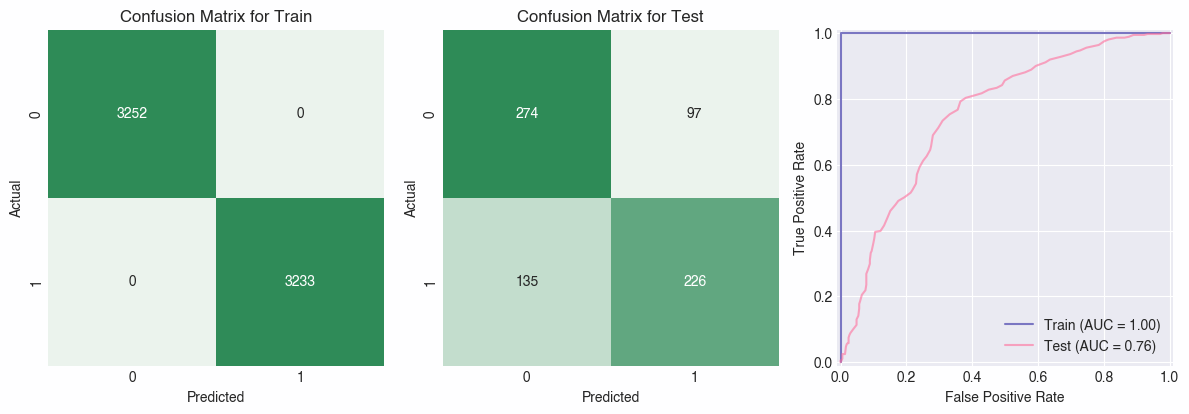

In [13]:
# predict & proba
pred_test = rf_RFE_defaults.predict(X_test[feat_RFE])
proba_test = rf_RFE_defaults.predict_proba(X_test[feat_RFE])

pred_train = rf_RFE_defaults.predict(X_train[feat_RFE])
proba_train = rf_RFE_defaults.predict_proba(X_train[feat_RFE])

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

In [14]:
# Get the best parameters and best estimator
em.model_info(rf_RFE_defaults)


 ----- RandomForestClassifier -----
   has on average 2020 nodes
   has on average a maximum depth of 26



-----

#### grid I 

In [15]:
# grid
param_grid_rf = {
    "classifier__max_depth": [7, 9, 11],
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__min_samples_leaf": [20, 30, 40],
    "classifier__min_samples_split": [40, 50, 60],
    "classifier__n_estimators": [100, 200, 300],
}

# Create GridSeardchCV object & fit it
gs_rf_RFE_v1 = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=1,
)

# set file & folder name
model_name = "RF_RFE_grid_v1.pickle"

# fit or load
gs_rf_RFE_v1 = em.fit_or_load(
    gs_rf_RFE_v1, X_train[feat_RFE], y_train, model_name, folder=folder_name
)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
 -> model saved in: '../../models/dev/RF_RFE_CV/RF_RFE_grid_v1.pickle'


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.749     0.749     0.749      3252
           1      0.748     0.747     0.748      3233

    accuracy                          0.748      6485
   macro avg      0.748     0.748     0.748      6485
weighted avg      0.748     0.748     0.748      6485

f(0.5)-score: 0.748
f(2.0)-score: 0.747

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.693     0.725     0.709       371
           1      0.703     0.670     0.687       361

    accuracy                          0.698       732
   macro avg      0.698     0.698     0.698       732
weighted avg      0.698     0.698     0.698       732

f(0.5)-score: 0.697
f(2.0)-score: 0.677



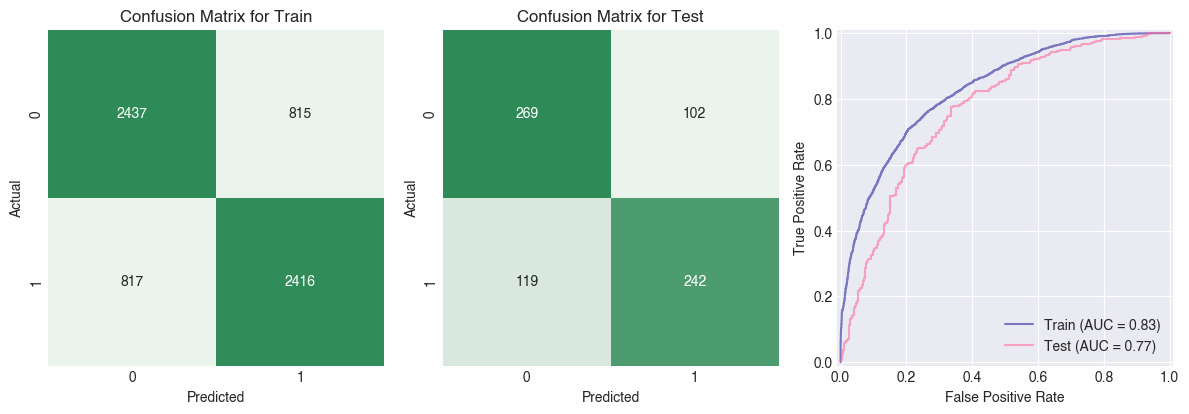

In [16]:
# predict & proba
pred_test = gs_rf_RFE_v1.predict(X_test[feat_RFE])
proba_test = gs_rf_RFE_v1.predict_proba(X_test[feat_RFE])

pred_train = gs_rf_RFE_v1.predict(X_train[feat_RFE])
proba_train = gs_rf_RFE_v1.predict_proba(X_train[feat_RFE])

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

In [17]:
# Get the best parameters and best estimator
em.model_info(gs_rf_RFE_v1)

 --------------- GridSearchCV --------------- 

 ----- best estimator: -----
Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=9, min_samples_leaf=20,
                                        min_samples_split=60, n_jobs=-1,
                                        random_state=42))])

 ----- best parameter: -----
{'classifier__max_depth': 9,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 20,
 'classifier__min_samples_split': 60,
 'classifier__n_estimators': 100}

 ----- RandomForestClassifier -----
   has on average 173 nodes
   has on average a maximum depth of 9



-----

#### grid II 

In [18]:
# grid
param_grid_rf = {
    "classifier__max_depth": [7, 8],
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__min_samples_leaf": [25, 30, 35],
    "classifier__min_samples_split": [55, 60, 65],
    "classifier__n_estimators": [50, 100, 150, 200],
}

# Create GridSeardchCV object & fit it
gs_rf_RFE_v2 = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=1,
)

# set file & folder name
model_name = "RF_RFE_grid_v2.pickle"

# fit or load
gs_rf_RFE_v2 = em.fit_or_load(
    gs_rf_RFE_v2, X_train[feat_RFE], y_train, model_name, folder=folder_name
)

Fitting 5 folds for each of 144 candidates, totalling 720 fits
 -> model saved in: '../../models/dev/RF_RFE_CV/RF_RFE_grid_v2.pickle'


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.739     0.736     0.738      3252
           1      0.736     0.739     0.737      3233

    accuracy                          0.738      6485
   macro avg      0.738     0.738     0.738      6485
weighted avg      0.738     0.738     0.738      6485

f(0.5)-score: 0.736
f(2.0)-score: 0.738

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.694     0.728     0.711       371
           1      0.706     0.670     0.688       361

    accuracy                          0.699       732
   macro avg      0.700     0.699     0.699       732
weighted avg      0.700     0.699     0.699       732

f(0.5)-score: 0.698
f(2.0)-score: 0.677



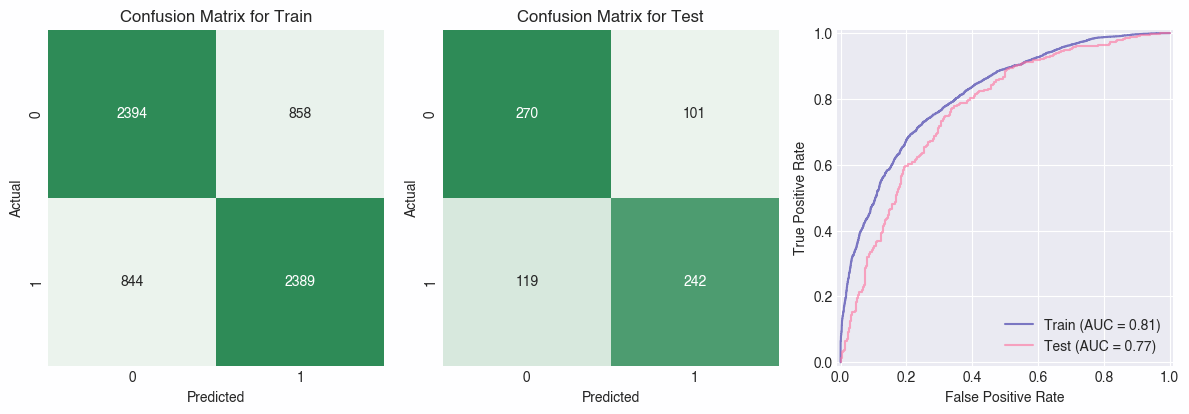

In [19]:
# predict & proba
pred_test = gs_rf_RFE_v2.predict(X_test[feat_RFE])
proba_test = gs_rf_RFE_v2.predict_proba(X_test[feat_RFE])

pred_train = gs_rf_RFE_v2.predict(X_train[feat_RFE])
proba_train = gs_rf_RFE_v2.predict_proba(X_train[feat_RFE])

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

In [20]:
# Get the best parameters and best estimator
em.model_info(gs_rf_RFE_v2)

 --------------- GridSearchCV --------------- 

 ----- best estimator: -----
Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=8, min_samples_leaf=25,
                                        min_samples_split=65, n_estimators=150,
                                        n_jobs=-1, random_state=42))])

 ----- best parameter: -----
{'classifier__max_depth': 8,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 25,
 'classifier__min_samples_split': 65,
 'classifier__n_estimators': 150}

 ----- RandomForestClassifier -----
   has on average 138 nodes
   has on average a maximum depth of 8



-----

#### grid III

In [21]:
# grid
param_grid_rf = {
    "classifier__max_depth": [7],
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__min_samples_leaf": [30, 35],
    "classifier__min_samples_split": [50, 55, 60],
    "classifier__n_estimators": [100, 150, 200],
}

# Create GridSeardchCV object & fit it
gs_rf_RFE_v3 = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=1,
)

# set file & folder name
model_name = "RF_RFE_grid_v3.pickle"

# fit or load
gs_rf_RFE_v3 = em.fit_or_load(
    gs_rf_RFE_v3, X_train[feat_RFE], y_train, model_name, folder=folder_name
)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
 -> model saved in: '../../models/dev/RF_RFE_CV/RF_RFE_grid_v3.pickle'


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.728     0.728     0.728      3252
           1      0.726     0.726     0.726      3233

    accuracy                          0.727      6485
   macro avg      0.727     0.727     0.727      6485
weighted avg      0.727     0.727     0.727      6485

f(0.5)-score: 0.726
f(2.0)-score: 0.726

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.701     0.747     0.723       371
           1      0.721     0.673     0.696       361

    accuracy                          0.710       732
   macro avg      0.711     0.710     0.710       732
weighted avg      0.711     0.710     0.710       732

f(0.5)-score: 0.711
f(2.0)-score: 0.682



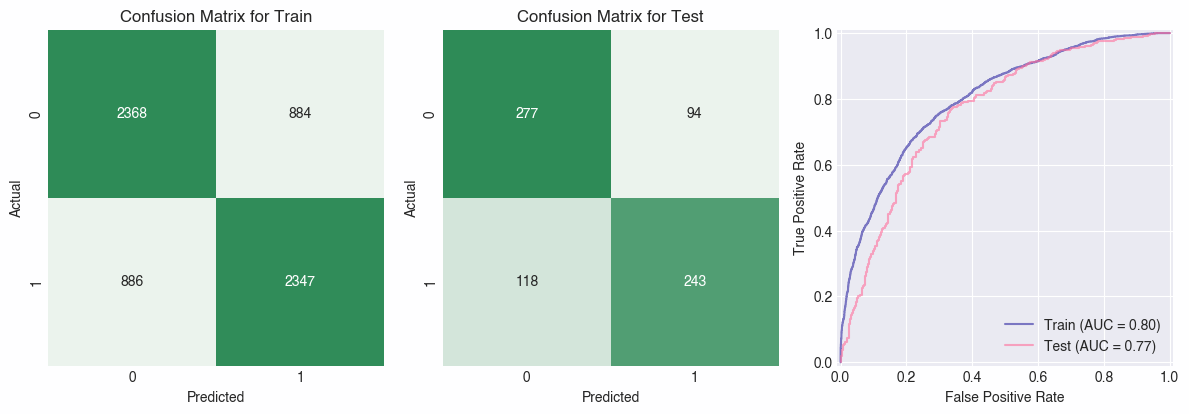

In [22]:
# predict & proba
pred_test = gs_rf_RFE_v3.predict(X_test[feat_RFE])
proba_test = gs_rf_RFE_v3.predict_proba(X_test[feat_RFE])

pred_train = gs_rf_RFE_v3.predict(X_train[feat_RFE])
proba_train = gs_rf_RFE_v3.predict_proba(X_train[feat_RFE])

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

In [23]:
# Get the best parameters and best estimator
em.model_info(gs_rf_RFE_v3)

 --------------- GridSearchCV --------------- 

 ----- best estimator: -----
Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=7, min_samples_leaf=30,
                                        min_samples_split=50, n_estimators=150,
                                        n_jobs=-1, random_state=42))])

 ----- best parameter: -----
{'classifier__max_depth': 7,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 30,
 'classifier__min_samples_split': 50,
 'classifier__n_estimators': 150}

 ----- RandomForestClassifier -----
   has on average 114 nodes
   has on average a maximum depth of 7



-----

#### grid IV

In [24]:
# grid
param_grid_rf = {
    "classifier__max_depth": [1],
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__n_estimators": [50, 100, 150, 200, 250, 300],
}

# Create GridSeardchCV object & fit it
gs_rf_RFE_v4 = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=1,
)

# set file & folder name
model_name = "RF_RFE_grid_v4.pickle"

# fit or load
gs_rf_RFE_v4 = em.fit_or_load(
    gs_rf_RFE_v4, X_train[feat_RFE], y_train, model_name, folder=folder_name
)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
 -> model saved in: '../../models/dev/RF_RFE_CV/RF_RFE_grid_v4.pickle'


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.674     0.645     0.659      3252
           1      0.658     0.686     0.672      3233

    accuracy                          0.666      6485
   macro avg      0.666     0.666     0.666      6485
weighted avg      0.666     0.666     0.666      6485

f(0.5)-score: 0.663
f(2.0)-score: 0.680

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.691     0.693     0.692       371
           1      0.683     0.681     0.682       361

    accuracy                          0.687       732
   macro avg      0.687     0.687     0.687       732
weighted avg      0.687     0.687     0.687       732

f(0.5)-score: 0.683
f(2.0)-score: 0.682



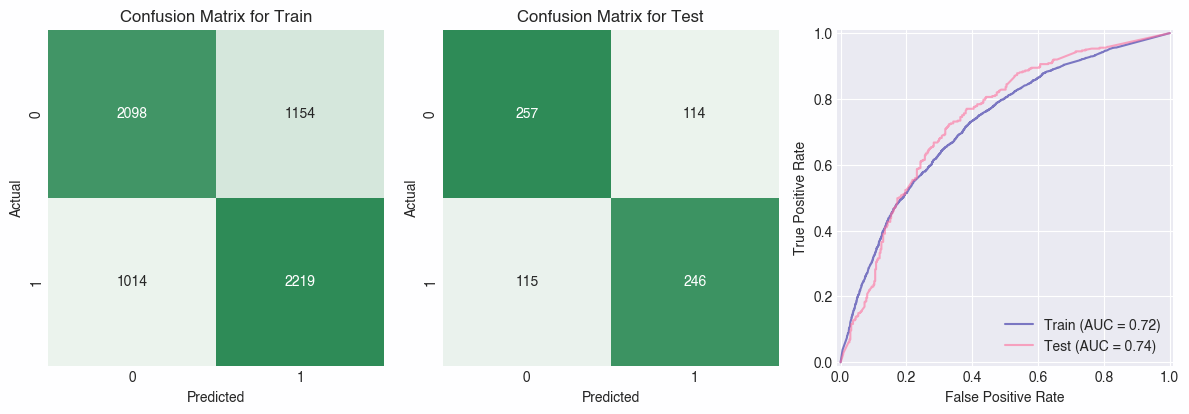

In [25]:
# predict & proba
pred_test = gs_rf_RFE_v4.predict(X_test[feat_RFE])
proba_test = gs_rf_RFE_v4.predict_proba(X_test[feat_RFE])

pred_train = gs_rf_RFE_v4.predict(X_train[feat_RFE])
proba_train = gs_rf_RFE_v4.predict_proba(X_train[feat_RFE])

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

 --------------- GridSearchCV --------------- 

 ----- best estimator: -----
Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=1, n_estimators=300,
                                        n_jobs=-1, random_state=42))])

 ----- best parameter: -----
{'classifier__max_depth': 1,
 'classifier__max_features': 'sqrt',
 'classifier__n_estimators': 300}

 ----- RandomForestClassifier -----
   has on average 3 nodes
   has on average a maximum depth of 1



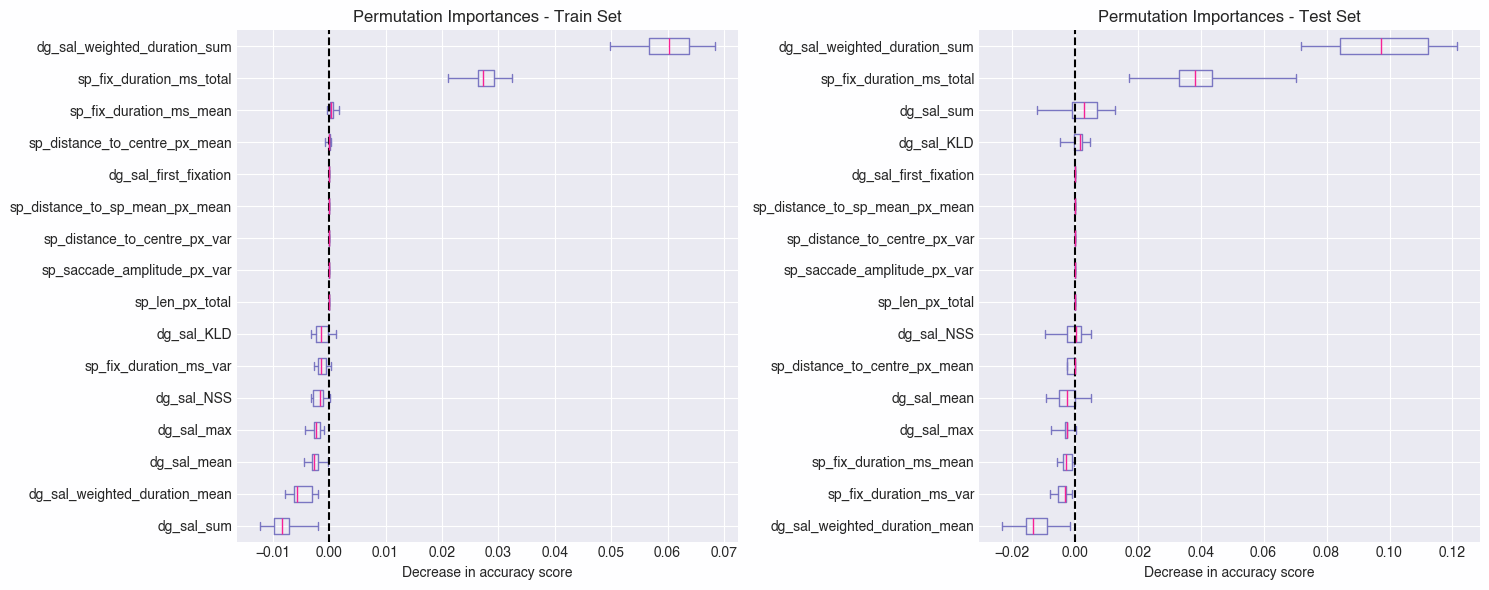

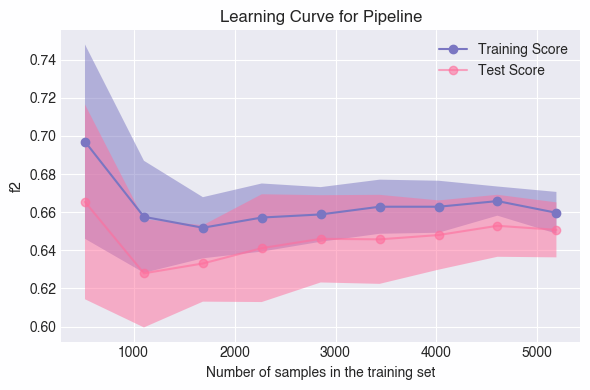

In [26]:
# Get the best parameters and best estimator
em.model_info(gs_rf_RFE_v4)

# # feature importances
em.feat_importance(gs_rf_RFE_v4, X_train[feat_RFE], y_train, X_test[feat_RFE], y_test)

# learning curves - for one model - f2 score
em.learning(gs_rf_RFE_v4.best_estimator_, X_train, y_train)

----
----

#### RFECV


In [27]:
estimator = RandomForestClassifier(
    random_state=RSEED,
    n_jobs=n_jobs,
    verbose=0,
)
selector_RFECV = RFECV(estimator, scoring=ftwo_scorer)
selector_RFECV = selector_RFECV.fit(X_train, y_train)
feat_RFECV = selector_RFECV.get_feature_names_out()
print(f"selected {selector_RFECV.n_features_} features: {feat_RFECV}")

selected 21 features: ['sp_fix_count' 'sp_fix_duration_ms_total' 'sp_fix_duration_ms_mean'
 'sp_fix_duration_ms_var' 'sp_len_px_total' 'sp_saccade_amplitude_px_mean'
 'sp_saccade_amplitude_px_var' 'sp_distance_to_centre_px_mean'
 'sp_distance_to_centre_px_var' 'sp_distance_to_sp_mean_px_mean'
 'sp_distance_to_sp_mean_px_var' 'dg_sal_first_fixation' 'dg_sal_mean'
 'dg_sal_sum' 'dg_sal_max' 'dg_sal_weighted_duration_sum'
 'dg_sal_weighted_duration_mean' 'dg_sal_KLD' 'dg_sal_NSS'
 'obj_t_abs_on_animate' 'obj_t_abs_on_background']


In [28]:
# Create GridSearchCV object & fit it
rf_RFECV_defaults = RandomForestClassifier(
    random_state=RSEED,
    n_jobs=n_jobs,
    verbose=0,
)

# set file & folder name
model_name = "RF_RFECV_defaults.pickle"

# fit or load
rf_RFECV_defaults = em.fit_or_load(
    rf_RFECV_defaults, X_train[feat_RFECV], y_train, model_name, folder=folder_name
)

 -> model saved in: '../../models/dev/RF_RFE_CV/RF_RFECV_defaults.pickle'


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      1.000     1.000     1.000      3252
           1      1.000     1.000     1.000      3233

    accuracy                          1.000      6485
   macro avg      1.000     1.000     1.000      6485
weighted avg      1.000     1.000     1.000      6485

f(0.5)-score: 1.000
f(2.0)-score: 1.000

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.688     0.739     0.713       371
           1      0.710     0.657     0.682       361

    accuracy                          0.698       732
   macro avg      0.699     0.698     0.697       732
weighted avg      0.699     0.698     0.698       732

f(0.5)-score: 0.698
f(2.0)-score: 0.666



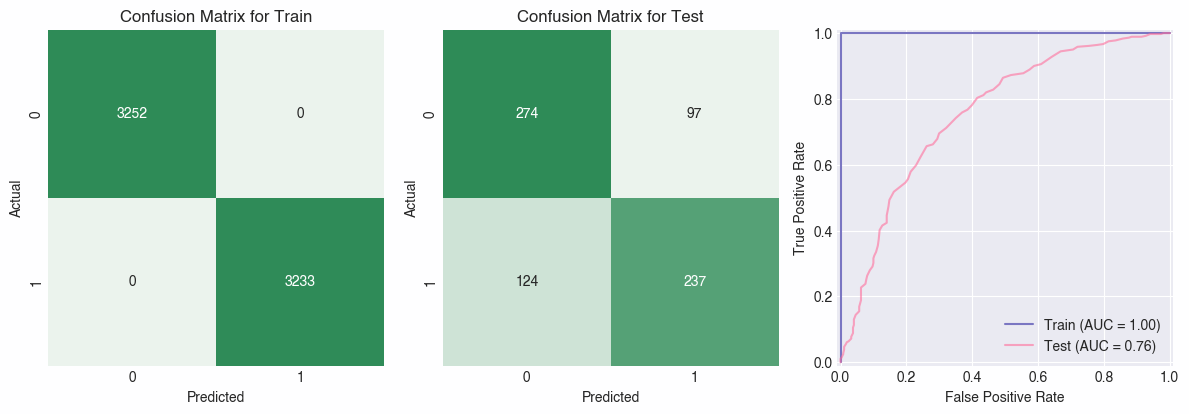

In [29]:
# predict & proba
pred_test = rf_RFECV_defaults.predict(X_test[feat_RFECV])
proba_test = rf_RFECV_defaults.predict_proba(X_test[feat_RFECV])

pred_train = rf_RFECV_defaults.predict(X_train[feat_RFECV])
proba_train = rf_RFECV_defaults.predict_proba(X_train[feat_RFECV])

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

-----

#### grid I 

In [30]:
# grid
param_grid_rf = {
    "classifier__max_depth": [7, 9, 11],
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__min_samples_leaf": [20, 30, 40],
    "classifier__min_samples_split": [40, 50, 60],
    "classifier__n_estimators": [100, 200, 300],
}

# Create GridSeardchCV object & fit it
gs_rf_RFECV_v1 = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=1,
)

# set file & folder name
model_name = "RF_RFECV_grid_v1.pickle"

# fit or load
gs_rf_RFECV_v1 = em.fit_or_load(
    gs_rf_RFECV_v1, X_train[feat_RFECV], y_train, model_name, folder=folder_name
)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
 -> model saved in: '../../models/dev/RF_RFE_CV/RF_RFECV_grid_v1.pickle'


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.760     0.756     0.758      3252
           1      0.756     0.760     0.758      3233

    accuracy                          0.758      6485
   macro avg      0.758     0.758     0.758      6485
weighted avg      0.758     0.758     0.758      6485

f(0.5)-score: 0.757
f(2.0)-score: 0.759

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.695     0.730     0.712       371
           1      0.708     0.670     0.688       361

    accuracy                          0.701       732
   macro avg      0.701     0.700     0.700       732
weighted avg      0.701     0.701     0.701       732

f(0.5)-score: 0.700
f(2.0)-score: 0.677



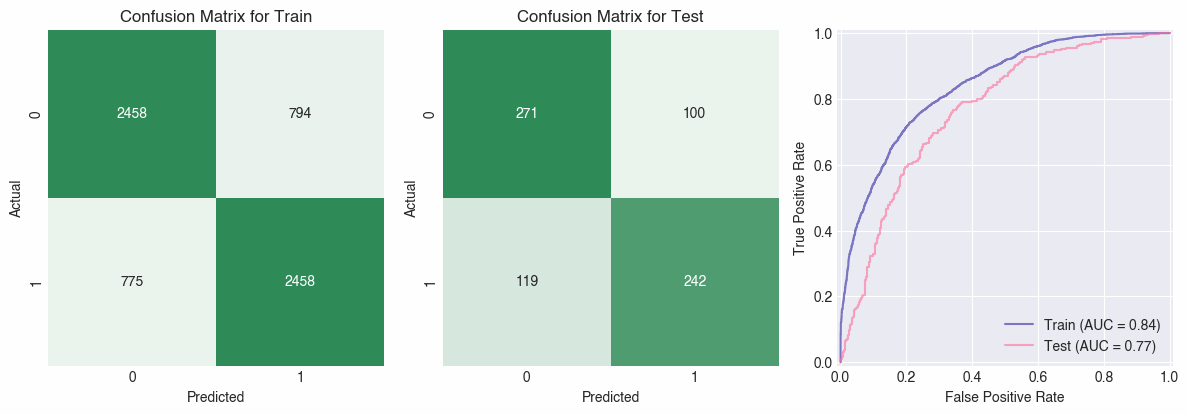

In [31]:
# predict & proba
pred_test = gs_rf_RFECV_v1.predict(X_test[feat_RFECV])
proba_test = gs_rf_RFECV_v1.predict_proba(X_test[feat_RFECV])

pred_train = gs_rf_RFECV_v1.predict(X_train[feat_RFECV])
proba_train = gs_rf_RFECV_v1.predict_proba(X_train[feat_RFECV])

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

In [32]:
# Get the best parameters and best estimator
em.model_info(gs_rf_RFECV_v1)

 --------------- GridSearchCV --------------- 

 ----- best estimator: -----
Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=11, min_samples_leaf=20,
                                        min_samples_split=60, n_jobs=-1,
                                        random_state=42))])

 ----- best parameter: -----
{'classifier__max_depth': 11,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 20,
 'classifier__min_samples_split': 60,
 'classifier__n_estimators': 100}

 ----- RandomForestClassifier -----
   has on average 210 nodes
   has on average a maximum depth of 11



-----

#### grid II

In [33]:
# grid
param_grid_rf = {
    "classifier__max_depth": [7, 9],
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__min_samples_leaf": [30, 40],
    "classifier__min_samples_split": [50, 60, 70],
    "classifier__n_estimators": [50, 100, 200, 300],
}

# Create GridSeardchCV object & fit it
gs_rf_RFECV_v2 = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=1,
)

# set file & folder name
model_name = "RF_RFECV_grid_v2.pickle"

# fit or load
gs_rf_RFECV_v2 = em.fit_or_load(
    gs_rf_RFECV_v2, X_train[feat_RFECV], y_train, model_name, folder=folder_name
)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
 -> model saved in: '../../models/dev/RF_RFE_CV/RF_RFECV_grid_v2.pickle'


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.741     0.734     0.738      3252
           1      0.735     0.742     0.739      3233

    accuracy                          0.738      6485
   macro avg      0.738     0.738     0.738      6485
weighted avg      0.738     0.738     0.738      6485

f(0.5)-score: 0.737
f(2.0)-score: 0.741

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.691     0.736     0.713       371
           1      0.709     0.662     0.685       361

    accuracy                          0.699       732
   macro avg      0.700     0.699     0.699       732
weighted avg      0.700     0.699     0.699       732

f(0.5)-score: 0.699
f(2.0)-score: 0.671



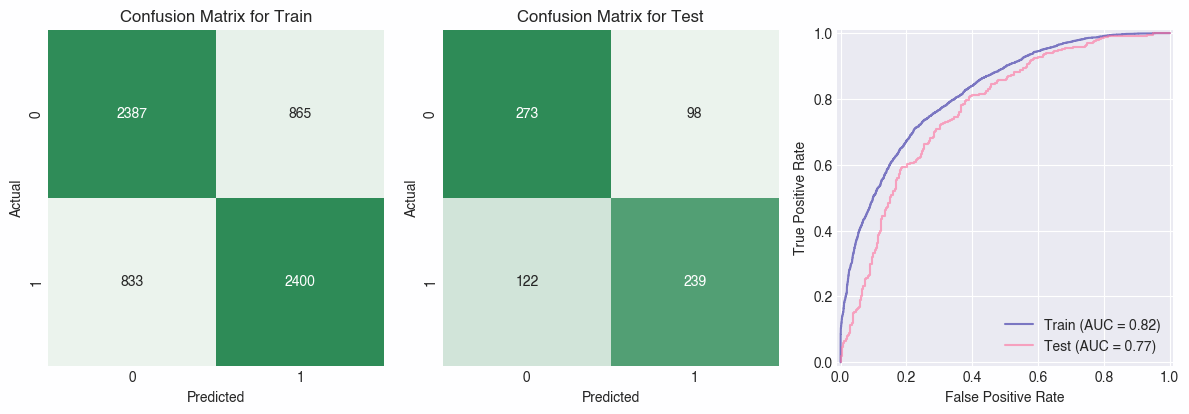

In [34]:
# predict & proba
pred_test = gs_rf_RFECV_v2.predict(X_test[feat_RFECV])
proba_test = gs_rf_RFECV_v2.predict_proba(X_test[feat_RFECV])

pred_train = gs_rf_RFECV_v2.predict(X_train[feat_RFECV])
proba_train = gs_rf_RFECV_v2.predict_proba(X_train[feat_RFECV])

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

In [35]:
# Get the best parameters and best estimator
em.model_info(gs_rf_RFECV_v2)

 --------------- GridSearchCV --------------- 

 ----- best estimator: -----
Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=9, min_samples_leaf=30,
                                        min_samples_split=50, n_jobs=-1,
                                        random_state=42))])

 ----- best parameter: -----
{'classifier__max_depth': 9,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 30,
 'classifier__min_samples_split': 50,
 'classifier__n_estimators': 100}

 ----- RandomForestClassifier -----
   has on average 170 nodes
   has on average a maximum depth of 9



-----

#### grid III   <--- final !!!

In [36]:
# grid
param_grid_rf = {
    "classifier__max_depth": [7],
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__min_samples_leaf": [40],
    "classifier__min_samples_split": [50],
    "classifier__n_estimators": [50, 100, 150, 200],
}

# Create GridSeardchCV object & fit it
gs_rf_RFECV_v3 = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=1,
)

# set file & folder name
model_name = "RF_RFECV_grid_v3.pickle"

# fit or load
gs_rf_RFECV_v3 = em.fit_or_load(
    gs_rf_RFECV_v3, X_train[feat_RFECV], y_train, model_name, folder=folder_name
)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
 -> model saved in: '../../models/dev/RF_RFE_CV/RF_RFECV_grid_v3.pickle'


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.713     0.713     0.713      3252
           1      0.711     0.712     0.712      3233

    accuracy                          0.712      6485
   macro avg      0.712     0.712     0.712      6485
weighted avg      0.712     0.712     0.712      6485

f(0.5)-score: 0.711
f(2.0)-score: 0.712

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.705     0.741     0.723       371
           1      0.719     0.681     0.700       361

    accuracy                          0.712       732
   macro avg      0.712     0.711     0.711       732
weighted avg      0.712     0.712     0.711       732

f(0.5)-score: 0.711
f(2.0)-score: 0.689



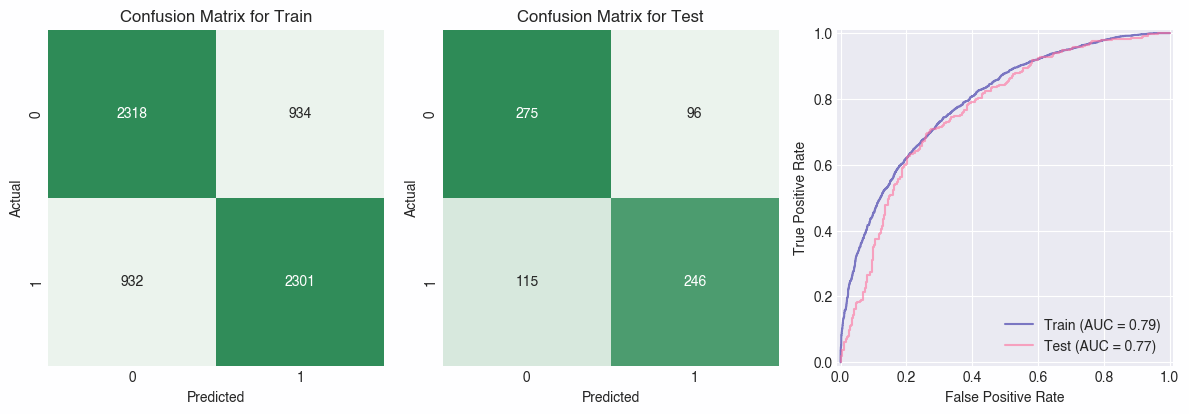

In [37]:
# predict & proba
pred_test = gs_rf_RFECV_v3.predict(X_test[feat_RFECV])
proba_test = gs_rf_RFECV_v3.predict_proba(X_test[feat_RFECV])

pred_train = gs_rf_RFECV_v3.predict(X_train[feat_RFECV])
proba_train = gs_rf_RFECV_v3.predict_proba(X_train[feat_RFECV])

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

 --------------- GridSearchCV --------------- 

 ----- best estimator: -----
Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=7, min_samples_leaf=40,
                                        min_samples_split=50, n_estimators=50,
                                        n_jobs=-1, random_state=42))])

 ----- best parameter: -----
{'classifier__max_depth': 7,
 'classifier__max_features': 'sqrt',
 'classifier__min_samples_leaf': 40,
 'classifier__min_samples_split': 50,
 'classifier__n_estimators': 50}

 ----- RandomForestClassifier -----
   has on average 99 nodes
   has on average a maximum depth of 7



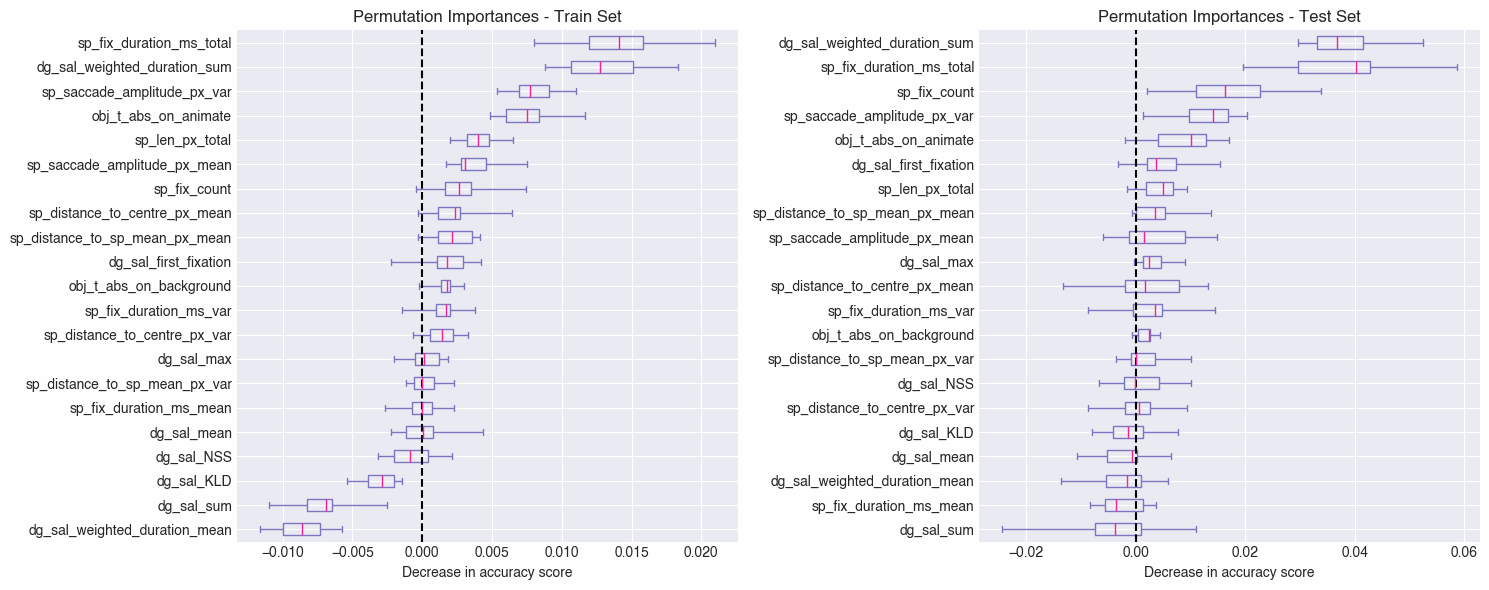

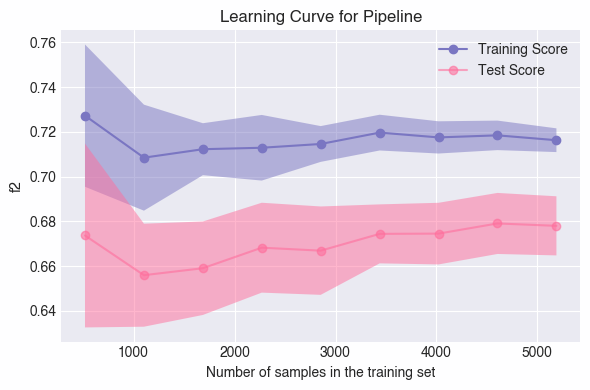

In [38]:
# Get the best parameters and best estimator
em.model_info(gs_rf_RFECV_v3)

# feature importances
em.feat_importance(gs_rf_RFECV_v3, X_train[feat_RFECV], y_train, X_test[feat_RFECV], y_test)

# learning curves - for one model - f2 score
em.learning(gs_rf_RFECV_v3.best_estimator_, X_train, y_train)

-----

#### grid IV

In [39]:
# grid
param_grid_rf = {
    "classifier__max_depth": [2],
    "classifier__max_features": ["sqrt", "log2"],
    "classifier__n_estimators": [50, 100, 150, 200, 250, 300],
}

# Create GridSeardchCV object & fit it
gs_rf_RFECV_v4 = GridSearchCV(
    rf_pipeline,
    param_grid=param_grid_rf,
    cv=5,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=1,
)

# set file & folder name
model_name = "RF_RFECV_grid_v4.pickle"

# fit or load
gs_rf_RFECV_v4 = em.fit_or_load(
    gs_rf_RFECV_v4, X_train[feat_RFECV], y_train, model_name, folder=folder_name, overwrite=True
)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
 -> model saved in: '../../models/dev/RF_RFE_CV/RF_RFECV_grid_v4.pickle'


-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.674     0.662     0.668      3252
           1      0.666     0.678     0.672      3233

    accuracy                          0.670      6485
   macro avg      0.670     0.670     0.670      6485
weighted avg      0.670     0.670     0.670      6485

f(0.5)-score: 0.669
f(2.0)-score: 0.676

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.697     0.714     0.706       371
           1      0.699     0.681     0.690       361

    accuracy                          0.698       732
   macro avg      0.698     0.698     0.698       732
weighted avg      0.698     0.698     0.698       732

f(0.5)-score: 0.695
f(2.0)-score: 0.685



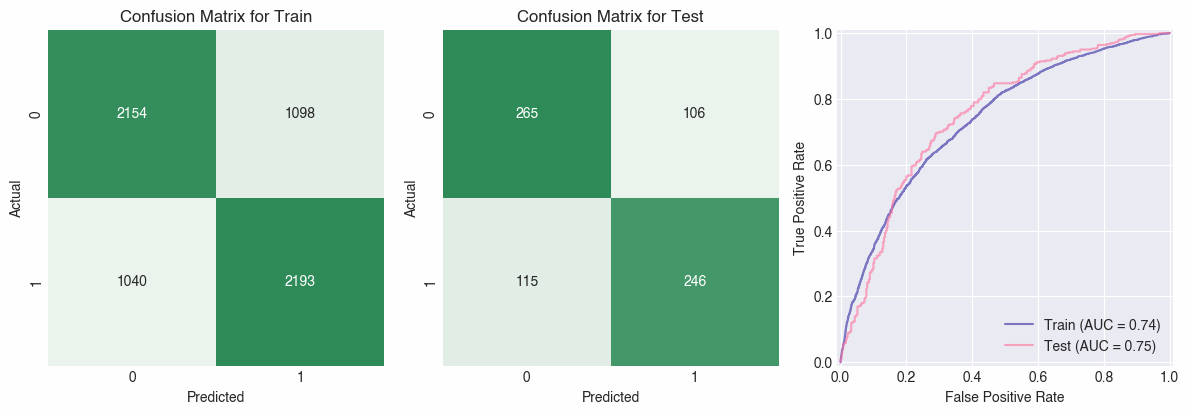

In [40]:
# predict & proba
pred_test = gs_rf_RFECV_v4.predict(X_test[feat_RFECV])
proba_test = gs_rf_RFECV_v4.predict_proba(X_test[feat_RFECV])

pred_train = gs_rf_RFECV_v4.predict(X_train[feat_RFECV])
proba_train = gs_rf_RFECV_v4.predict_proba(X_train[feat_RFECV])

# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

In [41]:
# Get the best parameters and best estimator
em.model_info(gs_rf_RFECV_v4)

 --------------- GridSearchCV --------------- 

 ----- best estimator: -----
Pipeline(steps=[('classifier',
                 RandomForestClassifier(max_depth=2, n_jobs=-1,
                                        random_state=42))])

 ----- best parameter: -----
{'classifier__max_depth': 2,
 'classifier__max_features': 'sqrt',
 'classifier__n_estimators': 100}

 ----- RandomForestClassifier -----
   has on average 7 nodes
   has on average a maximum depth of 2

